## 5 Data Modelling

The code in this notebook will attempt to build a model to predict county-level drug mortality rates from data on county economic and social characteristics. 

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import set_option
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error

plt.style.use('ggplot')

### 5.1 Prepare Data

In [2]:
# Read in data
drug_mort = pd.read_csv('./data/US_drug_mort_census_num.csv').drop(columns=['dm_min', 'dm_max', 'dm_median', 'FIPS.1'])

# Save FIPS identifier for later
FIPS = pd.DataFrame(drug_mort['FIPS']).reset_index()
drug_mort_prep = drug_mort.drop(columns=['FIPS', 'urban_2013'])

drug_mort.shape

(3135, 47)

In [3]:
# Take log of all the numeric data in input data, due to skewness
drug_mort_log = pd.DataFrame()
for col in drug_mort_prep.columns:
    drug_mort_log[col] = np.log(drug_mort_prep[col] + 0.1)
# Merge urban cat/ord variable back in    
drug_mort_log = pd.concat([drug_mort_log, drug_mort['urban_2013']], axis=1)    

In [4]:
# Create test and train data sets
X = drug_mort_log.drop(columns=['dm_mean'])
y = drug_mort_log['dm_mean']

test_size = 0.20
seed = 33

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

### 5.2 Evaluate several model types

In [5]:
# list numeric features for pipeline
num_vars = list(drug_mort_log.drop(columns=['urban_2013', 'dm_mean']))
# list categorical features for pipeline
cat_vars = ['urban_2013']

# Create numeric and categorical transformations
num_pipeline = Pipeline(steps=[('scaler', StandardScaler())])
cat_pipeline = Pipeline(steps=[('onehot', OneHotEncoder(categories='auto'))])

preprocessor = ColumnTransformer(transformers=[
        ('num', num_pipeline, num_vars),
        ('cat', cat_pipeline, cat_vars)])

In [6]:
X_train_scale = preprocessor.fit_transform(X_train)

In [7]:
# Evaluate Algorithms
# Test options and evaluation metric
num_folds = 10
seed = 33
scoring = 'r2'

# Spot Check Algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('RIDGE', Ridge()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR(gamma='auto')))

In [8]:
# evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = KFold(n_splits=num_folds, random_state=seed)
	cv_results = cross_val_score(model, X_train_scale, y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

LR: 0.528305 (0.051709)
RIDGE: 0.528484 (0.051724)
LASSO: -0.002476 (0.002159)
EN: -0.002476 (0.002159)
KNN: 0.516029 (0.060411)
CART: 0.113815 (0.142698)
SVR: 0.588837 (0.047052)


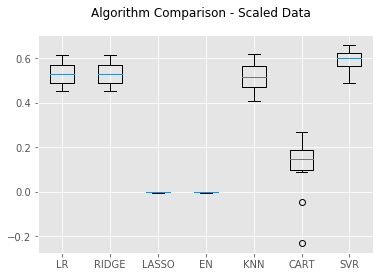

In [9]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison - Scaled Data')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Support vector regression, K nearest neighbors, and linear or ridge regression appear to be the most promising models. Next I will tune the KNN and SVR models to see if they can be further improved.

### 5.3 Tune most promising ML algorithms

### 5.3.1 Tune KNN regression

In [10]:
# KNN Algorithm tuning
k_values = np.array([1,3,5,7,9,11,13,15,17,19,21])
param_grid = dict(n_neighbors=k_values)
model = KNeighborsRegressor()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train_scale, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.524971 using {'n_neighbors': 9}
0.259533 (0.116220) with: {'n_neighbors': 1}
0.468265 (0.063444) with: {'n_neighbors': 3}
0.515985 (0.060415) with: {'n_neighbors': 5}
0.521351 (0.062971) with: {'n_neighbors': 7}
0.524971 (0.056265) with: {'n_neighbors': 9}
0.522077 (0.051427) with: {'n_neighbors': 11}
0.521860 (0.046555) with: {'n_neighbors': 13}
0.519279 (0.046988) with: {'n_neighbors': 15}
0.514574 (0.047589) with: {'n_neighbors': 17}
0.513684 (0.050321) with: {'n_neighbors': 19}
0.509152 (0.051427) with: {'n_neighbors': 21}


Tuning the number of neighbors results in a very slight increase in predictive ability, though still smaller then the SVR model.

### 5.3.2 Tune SVR models

In [11]:
# Tune scaled SVR - RBF kernel
kernel = 'rbf'
num_folds = 10
seed = 33
scoring = 'r2'

c_values = [1.0, 3.0, 5.0, 10.0, 15.0, 20.0]
gamma_values = [0.001, 0.005, 0.01, 0.05, 0.1]

param_grid = dict(C=c_values, gamma=gamma_values)
model = SVR(kernel=kernel)
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)

grid_result = grid.fit(X_train_scale, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.600227 using {'C': 5.0, 'gamma': 0.005}
0.541933 (0.051616) with: {'C': 1.0, 'gamma': 0.001}
0.585934 (0.055558) with: {'C': 1.0, 'gamma': 0.005}
0.597866 (0.053029) with: {'C': 1.0, 'gamma': 0.01}
0.534432 (0.037358) with: {'C': 1.0, 'gamma': 0.05}
0.445254 (0.033242) with: {'C': 1.0, 'gamma': 0.1}
0.557763 (0.052564) with: {'C': 3.0, 'gamma': 0.001}
0.597714 (0.054038) with: {'C': 3.0, 'gamma': 0.005}
0.595035 (0.053243) with: {'C': 3.0, 'gamma': 0.01}
0.522084 (0.044626) with: {'C': 3.0, 'gamma': 0.05}
0.446282 (0.037622) with: {'C': 3.0, 'gamma': 0.1}
0.564079 (0.052688) with: {'C': 5.0, 'gamma': 0.001}
0.600227 (0.054740) with: {'C': 5.0, 'gamma': 0.005}
0.583531 (0.057991) with: {'C': 5.0, 'gamma': 0.01}
0.514741 (0.045652) with: {'C': 5.0, 'gamma': 0.05}
0.446165 (0.037606) with: {'C': 5.0, 'gamma': 0.1}
0.572617 (0.052628) with: {'C': 10.0, 'gamma': 0.001}
0.591381 (0.058549) with: {'C': 10.0, 'gamma': 0.005}
0.561406 (0.068134) with: {'C': 10.0, 'gamma': 0.01}
0.509126

Tuning the SVR leads to an improved R2 of .604. 

In [12]:
# Tune scaled SVR - linear kernel
kernel = 'linear'
num_folds = 10
seed = 33
scoring = 'r2'

c_values = [0.1, 1.0, 2.0, 3.0, 5.0, 10.0]

param_grid = dict(C=c_values)
model = SVR(kernel=kernel) #gamma='auto'
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)

grid_result = grid.fit(X_train_scale, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.519753 using {'C': 0.1}
0.519753 (0.050680) with: {'C': 0.1}
0.519023 (0.050513) with: {'C': 1.0}
0.519307 (0.050518) with: {'C': 2.0}
0.519282 (0.050544) with: {'C': 3.0}
0.519047 (0.050476) with: {'C': 5.0}
0.519270 (0.050487) with: {'C': 10.0}


Linear SVR does not improve over rbf kernel.

In [13]:
# Tune scaled SVR - polynomial kernel
kernel = 'poly'
num_folds = 10
seed = 33
scoring = 'r2'

c_values = [0.1, 1.0, 2.0, 3.0, 5.0, 10.0]
gamma_values = [0.001, 0.005, 0.01, 0.05, 0.1]
degree_values = [0, 1, 2, 3]

param_grid = dict(C=c_values, gamma=gamma_values, degree=degree_values)
model = SVR(kernel=kernel)
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold, iid=False)

grid_result = grid.fit(X_train_scale, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.522427 using {'C': 3.0, 'degree': 1, 'gamma': 0.001}
-0.011810 (0.009783) with: {'C': 0.1, 'degree': 0, 'gamma': 0.001}
-0.011810 (0.009783) with: {'C': 0.1, 'degree': 0, 'gamma': 0.005}
-0.011810 (0.009783) with: {'C': 0.1, 'degree': 0, 'gamma': 0.01}
-0.011810 (0.009783) with: {'C': 0.1, 'degree': 0, 'gamma': 0.05}
-0.011810 (0.009783) with: {'C': 0.1, 'degree': 0, 'gamma': 0.1}
0.326982 (0.035515) with: {'C': 0.1, 'degree': 1, 'gamma': 0.001}
0.485622 (0.046920) with: {'C': 0.1, 'degree': 1, 'gamma': 0.005}
0.510328 (0.047730) with: {'C': 0.1, 'degree': 1, 'gamma': 0.01}
0.521490 (0.049730) with: {'C': 0.1, 'degree': 1, 'gamma': 0.05}
0.521535 (0.050034) with: {'C': 0.1, 'degree': 1, 'gamma': 0.1}
0.014048 (0.009203) with: {'C': 0.1, 'degree': 2, 'gamma': 0.001}
0.231920 (0.033414) with: {'C': 0.1, 'degree': 2, 'gamma': 0.005}
0.355096 (0.052979) with: {'C': 0.1, 'degree': 2, 'gamma': 0.01}
0.497516 (0.087150) with: {'C': 0.1, 'degree': 2, 'gamma': 0.05}
0.474011 (0.108014) 

The ploynomial kernal also does not outperform the rbf kernal, although the best model is very similar to the best rbf model. 

The highest R2 score among all tested models is  0.604, from the SVR model with an rbf kernel using C=1.0 and gamma =  0.005. Several models yield similar results, however, so I will apply the best of each model type to the test set for the final determination.

### 5.4 Validate best models against hold-out data

In [14]:
# Scale test data using pipeline applied to training data
X_test_scale = preprocessor.fit_transform(X_test)

In [15]:
# Evaluate Algorithms on train and test data

seed = 33
scoring = 'r2'

# Test Promising Algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('RIDGE', Ridge()))
models.append(('KNN', KNeighborsRegressor(n_neighbors=9)))
models.append(('SVR_rbf', SVR(C=5.0 , gamma=0.005, kernel='rbf')))
models.append(('SVR_lin', SVR(C=0.1, kernel='linear')))
models.append(('SVR_poly', SVR(C=0.1 , gamma=0.05, degree=2, kernel='poly')))

# evaluate each model in turn
names = []
results = []
for name, model in models:
    model.fit(X_train_scale, y_train)
    training_accuracy = model.score(X_train_scale, y_train)
    test_accuracy = model.score(X_test_scale, y_test)
    results.append((name, training_accuracy, 'Train'))
    results.append((name, test_accuracy, 'Test'))
    #names.append(name)
    print('Model: ' + name)
    print("    Score on training data: {:2f}".format(training_accuracy))
    print("    Score on test data:     {:2f}".format(test_accuracy))


Model: LR
    Score on training data: 0.562987
    Score on test data:     0.542588
Model: RIDGE
    Score on training data: 0.562976
    Score on test data:     0.542654
Model: KNN
    Score on training data: 0.633173
    Score on test data:     0.544588
Model: SVR_rbf
    Score on training data: 0.737294
    Score on test data:     0.601505
Model: SVR_lin
    Score on training data: 0.551673
    Score on test data:     0.525949
Model: SVR_poly
    Score on training data: 0.669652
    Score on test data:     0.440507


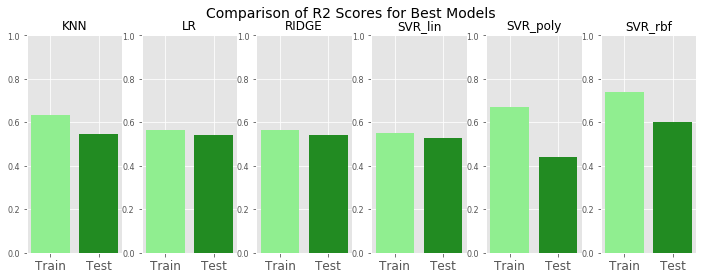

In [16]:
# Make bar charts for scores from each model
model_test = pd.DataFrame(results, columns=['Model', 'Score', 'Set'])
model_chart = model_test.pivot(index='Set', columns='Model')['Score'].fillna(0).reset_index()

plt.style.use('fast')
fig = plt.figure()
fig.suptitle('Comparison of R2 Scores for Best Models',  fontsize=14)
data=model_chart.sort_values('Set', ascending=False)

num=1
for column in  data.drop(columns = ['Set']):                                                   
    # Find the right spot on the plot
    plot_num =  "16" + str(num)
    plt.subplot(plot_num)
    #add_subplot(plot_num, **kwargs)
    fig.set_size_inches(12, 4, forward=True)
    
    plot_var =  data[column]
    plt.bar(data['Set'], data[column],  color=['lightgreen', 'forestgreen']) 
    plt.tight_layout
    plt.ylim(0, 1.0)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=8)
    #plt.xlabel("Cluster")
    #plt.ylabel("R2 Score", fontsize=12)
    plt.title(column, fontsize=12) #column, loc='left', fontsize=12, fontweight=0, color=palette(num) )
    
    num+=1
plt.show()    

This chart demonstrates that the support vector regresson model using the radial basis function kernel produces the highest R-square scores. And although the test score is noticeably lower than that for the training data, the R2 score for the test data using the SVR_rbf model still outperforms the other models.

Now that we have our best-fit model, we can examine the errors it produces to look for insight as to how to improve the model.

In [17]:
# Recreate best model and generate predictions
seed = 33
scoring = 'r2'

model = SVR(C=5.0 , gamma=0.005, kernel='rbf')
model.fit(X_train_scale, y_train)
y_pred_train = model.predict(X_train_scale)
y_pred_test = model.predict(X_test_scale)

In [18]:
#Combine actual and predicted y - Train Set
y_train_df = pd.DataFrame(y_train).reset_index()
y_train_pred_df = pd.DataFrame(y_pred_train, columns=['y_pred'])
y_train_all = pd.concat([y_train_df, y_train_pred_df], axis=1, sort=False)
y_train_all['set'] = "train"

#Combine actual and predicted y - Test Set
y_test_df = pd.DataFrame(y_test).reset_index()
y_test_pred_df = pd.DataFrame(y_pred_test, columns=['y_pred'])
y_test_all = pd.concat([y_test_df, y_test_pred_df], axis=1, sort=False)
y_test_all['set'] = "test"

# Combine Train and Test
pred_error = pd.concat([y_test_all, y_train_all], axis=0)
pred_error = pred_error.rename(columns={'dm_mean':'y_actual'})
#pred_error.head(2)

In [19]:
# Merge in FIPS info
pred_error = pred_error.merge(drug_mort, left_on='index', right_index=True, how='left')

# Take antilogs of drug mortality
pred_error['drug_mort_actual'] =  np.exp(pred_error['y_actual'])
pred_error['drug_mort_pred'] =  np.exp(pred_error['y_pred'])
#  Prediction error
pred_error['pred_error'] = pred_error['drug_mort_pred'] - pred_error['drug_mort_actual']

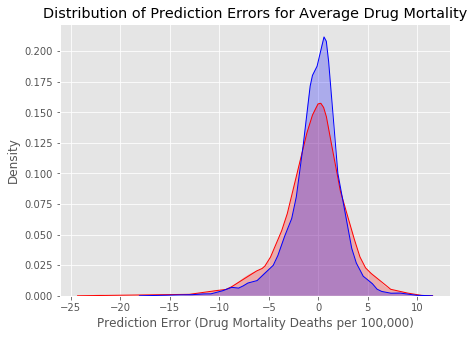

In [20]:
hist_train = pred_error[pred_error['set']=="train"]
hist_test = pred_error[pred_error['set']=="test"]
train = hist_train.pred_error

fig, ax = plt.subplots()

fig.set_size_inches(7, 5, forward=True)
sns.kdeplot(hist_test.pred_error, shade=True, linewidth=1, legend=False, color='r')
sns.kdeplot(train, shade=True, linewidth=1, legend=False, color='b')
plt.title('Distribution of Prediction Errors for Average Drug Mortality')
ax.set_xlabel("Prediction Error (Drug Mortality Deaths per 100,000)")
ax.set_ylabel("Density")

#plt.hist(hist_test.pred_error, edgecolor = 'k', bins = 20)
plt.show()

This density plot shows that the prediction errors for both the train and test sets are skewed to the left. This means there are a few counties for which the model fails to predict high levels of average drug mortality. We can identify those counties and explore some features.

In [21]:
# get county labels
counties = pd.read_csv('./data/drug_mort_2016.csv')
counties = counties[['FIPS', 'county', 'State']]
#counties.head()

In [22]:
pred = pred_error.merge(counties, on='FIPS', how='left')
low = pred.sort_values('pred_error', ascending=True)

low[['drug_mort_pred', 'drug_mort_actual', 'pred_error', 'county', 'State', 'urban_2013']].head(20)

,drug_mort_pred,drug_mort_actual,pred_error,county,State,urban_2013
267,10.440407,32.544444,-22.104037,"Rio Arriba County, NM",New Mexico,5.0
2503,10.218112,26.988889,-16.770777,"St. Bernard Parish, LA",Louisiana,2.0
354,11.911121,27.988889,-16.077767,"Carbon County, UT",Utah,5.0
2105,2.487417,15.433333,-12.945917,"Daniels County, MT",Montana,6.0
1617,11.026273,23.433333,-12.407061,"Starke County, IN",Indiana,6.0
13,12.938802,25.322222,-12.383420,"Summers County, WV",West Virginia,6.0
37,5.085411,17.433333,-12.347922,"Baylor County, TX",Texas,6.0
2183,10.169477,22.322222,-12.152745,"Mineral County, MT",Montana,6.0
654,17.343736,29.322222,-11.978486,"Baltimore city, MD",Maryland,1.0
1165,7.184044,18.988889,-11.804845,"Bear Lake County, ID",Idaho,6.0


In [24]:
#Save predictions and errors for later use
#pred.to_csv('./data/opioid_pred.csv')

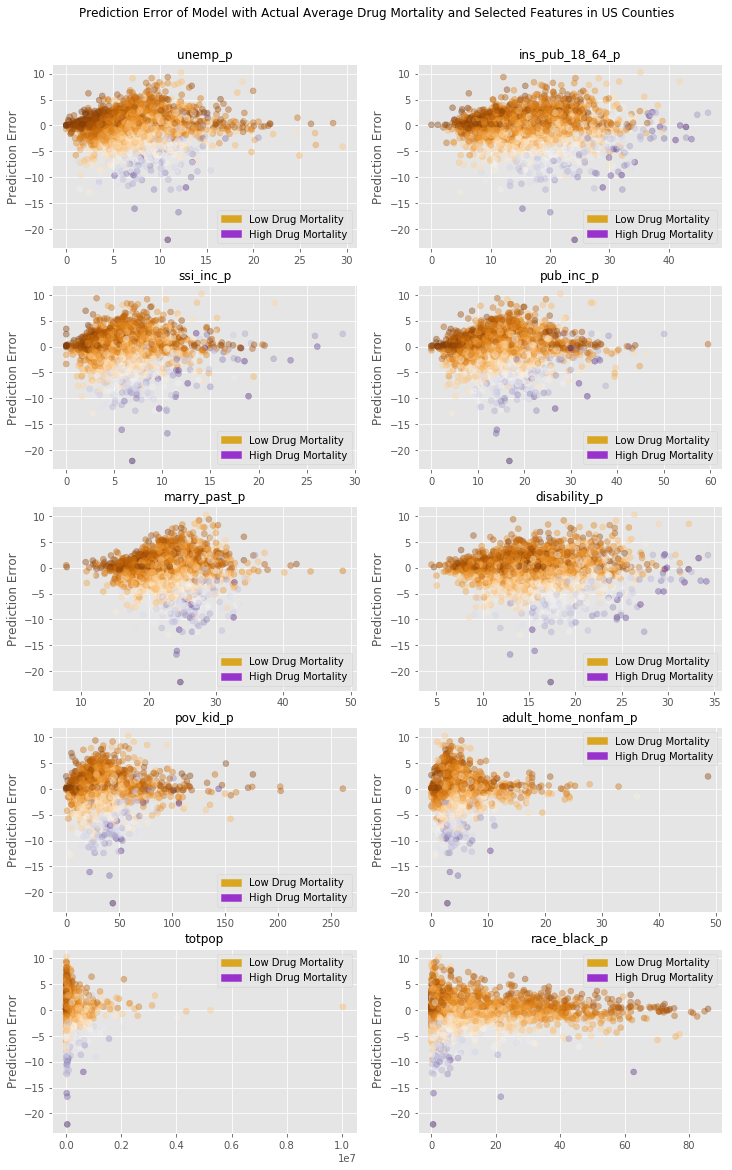

In [29]:
# Look at counties with high prediction errors compared to other counties
import matplotlib.patches as mpatches
correlates = ['unemp_p', 'ins_pub_18_64_p', 'ssi_inc_p', 'pub_inc_p', 'marry_past_p','disability_p', 
              'pov_kid_p', 'adult_home_nonfam_p', 'totpop', 'race_black_p']

fig = plt.figure()
fig.suptitle("Prediction Error of Model with Actual Average Drug Mortality and Selected Features in US Counties", y=0.90)

num=1
for var in  correlates:
    # Find the right spot on the plot
    plt.subplot(10, 2, num)
    fig.set_size_inches(12, 40, forward=True)
    
    plot_var =  pred[var]
    plt.scatter(plot_var, pred.pred_error, alpha=.4, c=pred.drug_mort_actual, cmap='PuOr')
    title = var

    plt.title(title, fontsize=12)
    plt.ylabel("Prediction Error")
   
    pur_patch = mpatches.Patch(color='darkorchid', label='High Drug Mortality')
    org_patch = mpatches.Patch(color ='goldenrod', label='Low Drug Mortality')
    plt.legend(handles=[org_patch, pur_patch])
    num+=1
      
plt.show()      

These scatterplots map the model's prediction error against several predictive features. There do not appear to be any relationships between these features and the prediction error, because they have been accounted for in the model. The orange counties indicate low actual average drug mortality rates while the purple represent high mortality. For many of the features, the underestimated counties (purple) are spread evenly across the x-axis. For others though--such as  total population, child poverty, adults in non-family homes, and percent Black--the underestimated counties do seem to be located in a narrow range along the x-axis. But with many other counties also in these bands, additional features are probably needed to achieve better  modelling of the data.

## 5.5 Discussion

This data science project has attempted to build a model to predict average drug mortality rates for US counties using a variety of socioeconomic features. After testing and tuning several machine learning algorithms, the best fitting model is a nonlinear support vector regression model. The R-square for this model is 0.60. R-square is sometimes interpreted as the percent of the variance of the outcome variable that can be explained by the input features (or independent variables). Thus this model 'explains' somewhat more than half of the variation across counties in average drug mortality rates. Obviously we would like to achieve a greater degree of accuracy, but this is actually a fairly good result for social science research.

Nonlinear relationships were observed in previous exploratory analysis, so it not surprising that an rbf kernel provided a better fit than any of the linear models. Unfortunately, the support vector machine model operates as a 'black box' and cannot provide any information about relative feature importance. For this use case we would ideally like to be able to decribe the socioeconomic factors most associated with higher drug mortality rates. Understanding these associations can be helpful in planning for future placement and allocation of resources to fight the opioid epidemic. Our best clues come from the bivariate anaysis, which identified the following features as the top correlates of drug mortality:

| Correlation | Feature Name        | Description                                             |
|-------------|---------------------|---------------------------------------------------------|
| 0.474638    | unemp_p             | Unemployment rate                                       |
| 0.431599    | ins_pub_18_64_p     | Percent of adults with public insurance                 |
| 0.400171    | totpop              | Population                                              |
| 0.387905    | ssi_inc_p           | Percent of households with Supplemental Security Income |
| 0.385667    | pub_inc_p           | Percent of households with public assistance            |
| -0.343611   | labor_force_p       | Labor force participation rate                          |
| 0.340851    | marry_past_p        | Percent of adults married in the past                   |
| 0.318582    | disability_p        | Percent of adults with a disability                     |
| -0.318407   | earn_inc_p          | Percent of households with earned income                |
| 0.291051    | pov_kid_p           | Child poverty rate                                      |
| 0.278506    | kid_home_fam1_p     | Percent of children living in single-parent households  |
| -0.272750   | ins_priv_18_64_p    | Percent of adults with private insurance                |
| 0.260372    | pov_p               | Poverty rate (overall)                                  |
| 0.241284    | pov_adult_p         | Poverty rate (adults)                                   |
| 0.236611    | adult_home_nonfam_p | Percent of adults living in non-family households       |
| 0.208037    | kid_home_nonfam_p   | Percent of children living in non-family households     |
| -0.205553   | urban_2013          | Urbanization category (1=city thru 6=rural)             |
| 0.166502    | ins_none_18_64_p    | Percent of adults with no insurance                     |
| 0.162094    | race_black_p        | Percent Black                                           |
| 0.150648    | ss_inc_p            | Percent of households with Social Security income       |


These patterns point to an association between higher drug mortality rates and indicators of lower economic well-being, such as unemployment, reliance on public assistance and public insurance, and disability rates. These findings can be used to provide guidance to policy makers in directing resources towards communities most likely to experience significant levels of drug mortality.

This model could also be used to generate predicted drug mortality rates for later years by exposing the model to updated socioeconomic data. But one of the shortcomings of the model is that it fails to predict some of the highest rates of drug mortality that have been seen in the US. It may be possible to improve the model by adding additional features. Some features suggested by previous research that might be tried in future modelling attempts include:

- housing data such as median housing values and housing tenure data
- commerial activity or employment data, broken down by industry
- death rates from other despair-related causes, such as suicide
- commuting patterns
- availability of addiction recovery and support services